In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from datetime import datetime

In [ ]:
data = pd.read_csv('NY-House-Dataset.csv')

In [ ]:
# Define a function to remove outliers based on the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# **RF & SVM Regressor**

In [ ]:
translations = {
    "New York": "New York County",  # Generally refers to Manhattan
    "Kings County": "Kings County",  # Brooklyn
    "Queens County": "Queens County",
    "Queens": "Queens County",
    "Richmond County": "Richmond County",  # Staten Island
    "Brooklyn": "Kings County",
    "Bronx County": "Bronx County",
    "New York County": "New York County",  # Manhattan
    "The Bronx": "Bronx County",
    "Staten Island": "Richmond County",
    "Manhattan": "New York County",
    "Riverdale": "Bronx County",  # Neighborhood in The Bronx
    "Flushing": "Queens County", # Neighborhood in Queens
    "Coney Island": "Kings County",  # Neighborhood in Brooklyn
    "East Bronx": "Bronx County",  # Part of The Bronx
    "Brooklyn Heights": "Kings County",  # Neighborhood in Brooklyn
    "Jackson Heights": "Queens County",  # Neighborhood in Queens
    "Rego Park": "Queens County",  # Neighborhood in Queens
    "Fort Hamilton": "Kings County",  # Neighborhood in Brooklyn
    "Dumbo": "Kings County",  # Neighborhood in Brooklyn
    "Snyder Avenue": "Kings County"  # Assuming this is in Brooklyn; otherwise, needs correction
}

data["SUBLOCALITY"] = data["SUBLOCALITY"].apply(lambda row: translations[row])

data["SUBLOCALITY"].nunique()

# Selecting relevant features and target
X = data[['TYPE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'SUBLOCALITY']]
y = data['PRICE']

# Check for nulls in the selected columns
null_counts = X.isnull().sum().sum() + y.isnull().sum()

# Remove rows with any null values in the selected features or target
data_clean = data[['TYPE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'LATITUDE', 'LONGITUDE', 'PRICE', 'SUBLOCALITY']].dropna()

# Remove outliers from 'PRICE'
data_no_outliers = remove_outliers(data_clean, 'PRICE')

# Splitting the data into features and target without outliers and nulls
X_no_outliers = data_no_outliers[['TYPE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'SUBLOCALITY']]
y_no_outliers = data_no_outliers['PRICE']

# Splitting the data into training and testing sets
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

# Preprocessing: One-hot encoding for 'TYPE'
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['TYPE','SUBLOCALITY']),
    ],
    remainder='passthrough'  # Keep the other columns unchanged
)

# Random Forest model pipeline
rf_pipeline = make_pipeline(
    preprocessor,
    RandomForestRegressor(n_estimators=100, random_state=42)
)

# SVM model pipeline
svm_pipeline = make_pipeline(
    preprocessor,
    SVR(C=1.0, epsilon=0.2)
)

# Fit the models with the cleaned data
rf_pipeline.fit(X_train_no, y_train_no)
svm_pipeline.fit(X_train_no, y_train_no)

# Predictions with the cleaned data
rf_predictions_no = rf_pipeline.predict(X_test_no)
svm_predictions_no = svm_pipeline.predict(X_test_no)

# Evaluation with the cleaned data
rf_mae_no = mean_absolute_error(y_test_no, rf_predictions_no)
svm_mae_no = mean_absolute_error(y_test_no, svm_predictions_no)

rf_rmse_no = np.sqrt(mean_squared_error(y_test_no, rf_predictions_no))
svm_rmse_no = np.sqrt(mean_squared_error(y_test_no, svm_predictions_no))

print('Nulls:', null_counts)
print('Original Data Shape:', data_clean.shape[0])
print('Outliers_Removed Shape:', data_no_outliers.shape[0])
print('Random Forest Mean Absolute Error:', rf_mae_no)
print('Random Forest Root Mean Standard Error:',rf_rmse_no)
print('SVM Mean Absolute Error:', svm_mae_no)
print('SVM Root Mean Standard Error:', svm_rmse_no)


Nulls: 0
Original Data Shape: 4801
Outliers_Removed Shape: 4242
Random Forest Mean Absolute Error: 250330.86978287145
Random Forest Root Mean Standard Error: 384966.7482716962
SVM Mean Absolute Error: 457020.1480528345
SVM Root Mean Standard Error: 634691.5574913853


# **Time-Series**

In [ ]:
# Assuming 'data_no_outliers' is your DataFrame
number_of_rows = len(data_no_outliers)

# Generate random dates
np.random.seed(42)  # For reproducible results
random_dates = pd.date_range(start='2017-01-01', end='2018-12-31', periods=number_of_rows)
random_dates = np.random.choice(random_dates, size=number_of_rows, replace=True)

# Add the random dates to your DataFrame
data_no_outliers['DATE'] = random_dates

# Shuffle the DataFrame if necessary
data_no_outliers = data_no_outliers.sample(frac=1).reset_index(drop=True)

data_no_outliers['DATE'] = pd.to_datetime(data_no_outliers['DATE'])
data_no_outliers


<ipython-input-13-939d2eb39109>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_outliers['DATE'] = random_dates


,TYPE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE,PRICE,SUBLOCALITY,DATE
0,Multi-family home for sale,12,8.000000,5100.000000,40.574518,-74.006830,1998000,Kings County,2017-01-23 20:41:01.683565196
1,House for sale,3,2.000000,2000.000000,40.552849,-74.169938,849000,Richmond County,2018-04-24 21:28:54.213628856
2,Multi-family home for sale,5,2.000000,2184.207862,40.593969,-73.758887,848000,Queens County,2018-12-06 05:56:10.808771512
3,Multi-family home for sale,4,2.000000,2034.000000,40.866471,-73.845984,875000,Bronx County,2018-09-13 12:50:45.696769624
4,Contingent,7,4.000000,2268.000000,40.692774,-73.951031,2499000,Kings County,2018-12-26 08:36:47.026644656
...,...,...,...,...,...,...,...,...,...
4237,Co-op for sale,1,2.000000,2184.207862,40.759577,-73.964779,330000,New York County,2017-08-21 21:58:26.625795800
4238,Condo for sale,1,1.000000,561.000000,40.583957,-73.942085,399000,Kings County,2017-10-09 21:43:30.233435508
4239,Condo for sale,2,2.000000,1005.000000,40.856444,-73.937762,850000,New York County,2018-04-22 19:58:35.114359816
4240,Condo for sale,3,2.373861,1632.000000,40.577069,-74.161888,650000,Richmond County,2017-10-21 14:15:18.462626736


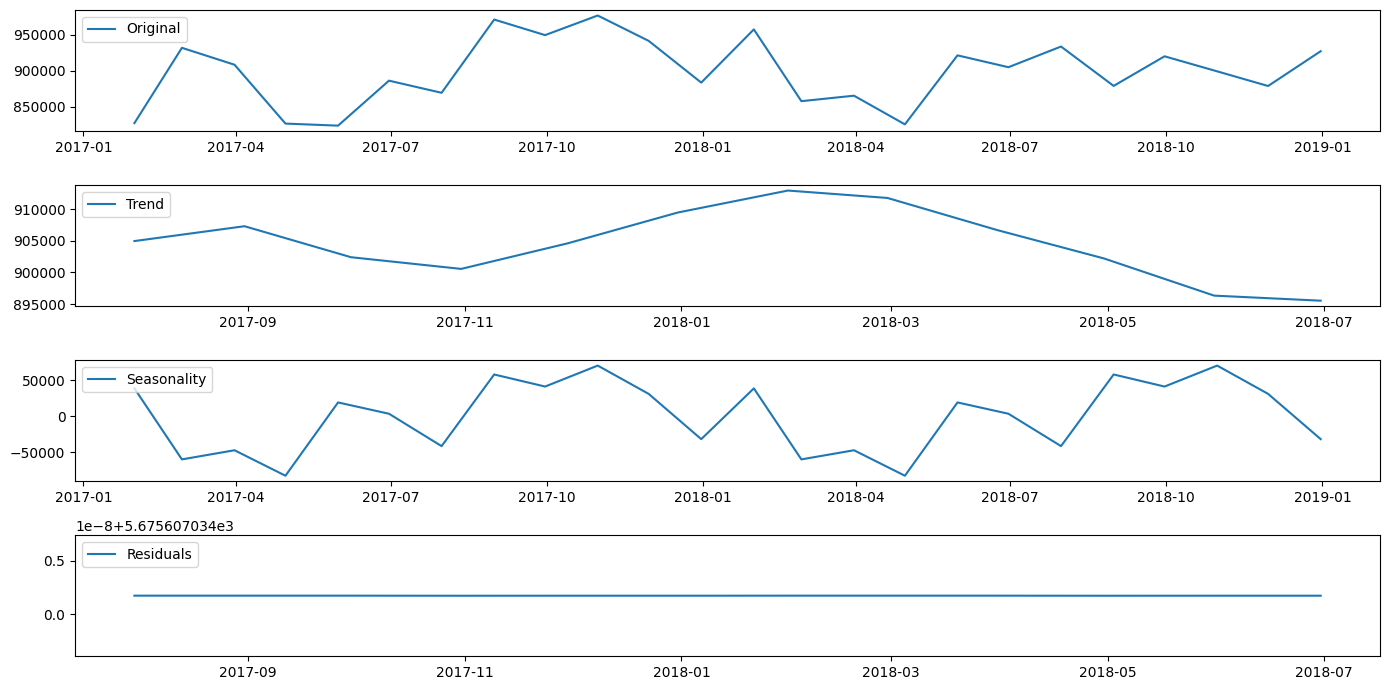

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# For the sake of this example, we're pretending the 'DATE' column has been set as the index
# and the DataFrame has been sorted by this index. We're simulating this with the existing data.

# Simulate resampling by month and calculating the mean price
data_no_outliers.set_index('DATE', inplace=True)  # Pretend 'DATE' is already in datetime format
monthly_prices = data_no_outliers['PRICE'].resample('M').mean()

# Decompose the time series
decomposition = seasonal_decompose(monthly_prices, model='additive')

# Plotting the original time series and its decomposed components
plt.figure(figsize=(14, 7))

plt.subplot(411)
plt.plot(monthly_prices, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal,label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


# **Random Forest and SVM Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Preliminary data cleaning
# For simplicity, we'll focus on a few relevant features and drop rows with missing values in these columns.
translations = {
    "New York": "New York County",  # Generally refers to Manhattan
    "Kings County": "Kings County",  # Brooklyn
    "Queens County": "Queens County",
    "Queens": "Queens County",
    "Richmond County": "Richmond County",  # Staten Island
    "Brooklyn": "Kings County",
    "Bronx County": "Bronx County",
    "New York County": "New York County",  # Manhattan
    "The Bronx": "Bronx County",
    "Staten Island": "Richmond County",
    "Manhattan": "New York County",
    "Riverdale": "Bronx County",  # Neighborhood in The Bronx
    "Flushing": "Queens County", # Neighborhood in Queens
    "Coney Island": "Kings County",  # Neighborhood in Brooklyn
    "East Bronx": "Bronx County",  # Part of The Bronx
    "Brooklyn Heights": "Kings County",  # Neighborhood in Brooklyn
    "Jackson Heights": "Queens County",  # Neighborhood in Queens
    "Rego Park": "Queens County",  # Neighborhood in Queens
    "Fort Hamilton": "Kings County",  # Neighborhood in Brooklyn
    "Dumbo": "Kings County",  # Neighborhood in Brooklyn
    "Snyder Avenue": "Kings County"  # Assuming this is in Brooklyn; otherwise, needs correction
}

data["SUBLOCALITY"] = data["SUBLOCALITY"].apply(lambda row: translations.get(row, row))  # Added default case handling

data_clean = data[['PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'TYPE', 'SUBLOCALITY']].dropna()

# Categorize 'PRICE' into categories (low, medium, high) using quantiles
price_categories = pd.qcut(data_clean['PRICE'], q=3, labels=['low', 'medium', 'high'])
data_clean['PRICE_CATEGORY'] = price_categories

# Encode the 'TYPE' and 'SUBLOCALITY' column since they are categorical
data_clean = pd.get_dummies(data_clean, columns=['TYPE', 'SUBLOCALITY'], drop_first=True)

# Splitting the data into features (X) and target (y)
X = data_clean.drop(['PRICE', 'PRICE_CATEGORY'], axis=1)
y = data_clean['PRICE_CATEGORY']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Time the tuning process using datetime
print("Start search time:", datetime.now())

# Define and tune the RandomForestClassifier with GridSearchCV
param = {
    'n_estimators': [300, 600, 900],
    'max_features': ['sqrt'],
    'max_depth': [2, 5, 9],
    'criterion': ['gini', 'entropy']
}

RF = RandomForestClassifier(random_state=10)
grid = GridSearchCV(estimator=RF, param_grid=param, scoring="accuracy", verbose=3, cv=5)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best estimator:", grid.best_estimator_)

# After fitting, extract and report feature importances
best_rf = grid.best_estimator_
feature_importances = best_rf.feature_importances_
feature_importance_dict = {feature: importance for feature, importance in zip(X_train.columns, feature_importances)}
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Displaying the feature importances
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

print("End search time:", datetime.now())

Start search time: 2024-05-04 21:24:41.935398
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, n_estimators=300;, score=0.682 total time=   0.6s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, n_estimators=300;, score=0.671 total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, n_estimators=300;, score=0.690 total time=   0.6s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, n_estimators=300;, score=0.719 total time=   0.6s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, n_estimators=300;, score=0.685 total time=   0.6s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, n_estimators=600;, score=0.680 total time=   1.7s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, n_estimators=600;, score=0.671 total time=   3.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, n_estimators=600;, score=0.686 total time=   3.4s
[CV 4


Accuracy: 0.7481789802289281


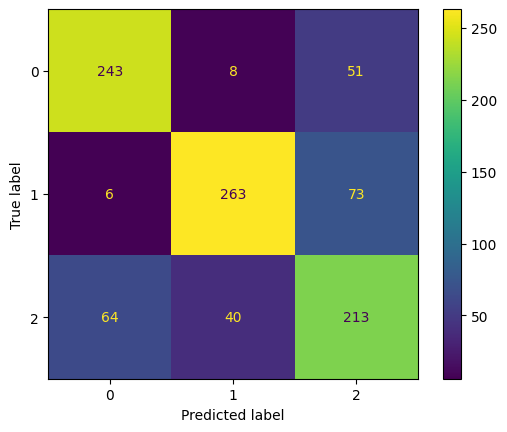

In [ ]:
# confusion matrix
from sklearn import metrics

final_model_rf = grid.best_estimator_

y_pred = final_model_rf.predict(X_test)

# get accuracy and confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)

cm = metrics.confusion_matrix(y_test,y_pred) # row - true value; column - predicted
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [ ]:
# SVM - Fine tuning with GridSearchCV
# using datetime to time the fine tuning process
from datetime import datetime
print("Start search time:", datetime.now())

# find the best parameters
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# SVM -- Tunning parameters
param = {
    'C':[.00001, .0001, .001, 0.01],
    'gamma': [.00001, .0001, .001, .01], # 1/n_features
    'kernel': ['rbf','linear']
}

SVM = SVC(random_state=10)


# search parameters: cv=cross validation blocks; verbose=higher value show more steps
# n_jobs=-1 uses all available CPU cores;
grid = GridSearchCV(estimator= SVM,
                    param_grid=param,
                    verbose=3, cv=3,
                    refit=True)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

print("Best estimator:", grid.best_estimator_)

# end grid search
print("End search time:", datetime.now())

Start search time: 2024-05-04 21:27:23.229812
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3] END ..C=1e-05, gamma=1e-05, kernel=rbf;, score=0.336 total time=   0.7s
[CV 2/3] END ..C=1e-05, gamma=1e-05, kernel=rbf;, score=0.335 total time=   0.6s
[CV 3/3] END ..C=1e-05, gamma=1e-05, kernel=rbf;, score=0.336 total time=   1.0s
[CV 1/3] END C=1e-05, gamma=1e-05, kernel=linear;, score=0.510 total time=   0.7s
[CV 2/3] END C=1e-05, gamma=1e-05, kernel=linear;, score=0.531 total time=   0.7s
[CV 3/3] END C=1e-05, gamma=1e-05, kernel=linear;, score=0.520 total time=   0.7s
[CV 1/3] END .C=1e-05, gamma=0.0001, kernel=rbf;, score=0.336 total time=   0.7s
[CV 2/3] END .C=1e-05, gamma=0.0001, kernel=rbf;, score=0.335 total time=   0.7s
[CV 3/3] END .C=1e-05, gamma=0.0001, kernel=rbf;, score=0.336 total time=   0.7s
[CV 1/3] END C=1e-05, gamma=0.0001, kernel=linear;, score=0.510 total time=   0.4s
[CV 2/3] END C=1e-05, gamma=0.0001, kernel=linear;, score=0.531 total time=   


Accuracy: 0.7138397502601457


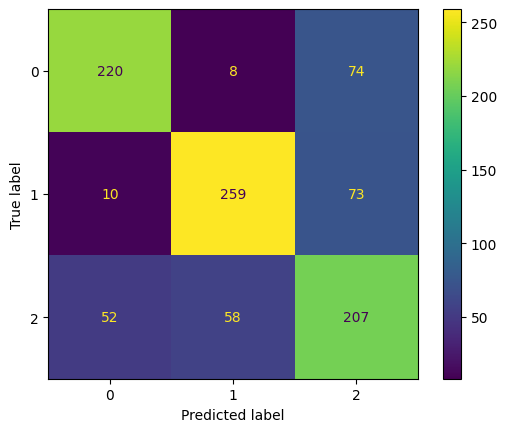

In [ ]:
# confusion matrix

final_model_svm = grid.best_estimator_

y_pred = final_model_svm.predict(X_test)

# get accuracy and confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)

cm = metrics.confusion_matrix(y_test,y_pred) # row - true value; column - predicted
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()
# disp.plot()
plt.show() # display all open figures

# **Sequential RNN**

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

translations = {
    "New York": "New York County",  # Generally refers to Manhattan
    "Kings County": "Kings County",  # Brooklyn
    "Queens County": "Queens County",
    "Queens": "Queens County",
    "Richmond County": "Richmond County",  # Staten Island
    "Brooklyn": "Kings County",
    "Bronx County": "Bronx County",
    "New York County": "New York County",  # Manhattan
    "The Bronx": "Bronx County",
    "Staten Island": "Richmond County",
    "Manhattan": "New York County",
    "Riverdale": "Bronx County",  # Neighborhood in The Bronx
    "Flushing": "Queens County", # Neighborhood in Queens
    "Coney Island": "Kings County",  # Neighborhood in Brooklyn
    "East Bronx": "Bronx County",  # Part of The Bronx
    "Brooklyn Heights": "Kings County",  # Neighborhood in Brooklyn
    "Jackson Heights": "Queens County",  # Neighborhood in Queens
    "Rego Park": "Queens County",  # Neighborhood in Queens
    "Fort Hamilton": "Kings County",  # Neighborhood in Brooklyn
    "Dumbo": "Kings County",  # Neighborhood in Brooklyn
    "Snyder Avenue": "Kings County"  # Assuming this is in Brooklyn; otherwise, needs correction
}

data["SUBLOCALITY"] = data["SUBLOCALITY"].apply(lambda row: translations[row])

data["SUBLOCALITY"].nunique()

# Selecting relevant columns
data_selected = data[['BEDS', 'BATH', 'PROPERTYSQFT', 'TYPE', 'PRICE', 'SUBLOCALITY']]

# Check for missing values
missing_data = data_selected.isnull().sum()
missing_data

# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for 'BEDS', 'BATH', 'PROPERTYSQFT', 'PRICE'
data_cleaned = data_selected.copy()
for column in ['BEDS', 'BATH', 'PROPERTYSQFT', 'PRICE']:
    data_cleaned = remove_outliers(data_cleaned, column)


# One-hot encoding the categorical variables
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(data_cleaned[['TYPE', 'SUBLOCALITY']])

# Create DataFrame from encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['TYPE', 'SUBLOCALITY']))

# Reset index on cleaned data to align with encoded data
data_cleaned.reset_index(drop=True, inplace=True)

# Concatenate encoded features with the rest of the numerical data
final_data = pd.concat([data_cleaned.drop(['TYPE', 'SUBLOCALITY'], axis=1), encoded_df], axis=1)

# Scale the numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(final_data[['BEDS', 'BATH', 'PROPERTYSQFT', 'PRICE']])

# Update the numeric features in the final DataFrame
final_data.update(pd.DataFrame(scaled_features, columns=['BEDS', 'BATH', 'PROPERTYSQFT', 'PRICE']))

# Split data into training and testing sets
X = final_data.drop('PRICE', axis=1)
y = final_data['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the RNN model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
model.evaluate(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/50
96/96 [==============================] - 8s 32ms/step - loss: 0.7728 - mae: 0.6655 - val_loss: 0.7544 - val_mae: 0.6369
Epoch 2/50
96/96 [==============================] - 2s 22ms/step - loss: 0.7292 - mae: 0.6394 - val_loss: 0.7548 - val_mae: 0.6524
Epoch 3/50
96/96 [==============================] - 2s 24ms/step - loss: 0.7268 - mae: 0.6368 - val_loss: 0.7505 - val_mae: 0.6378
Epoch 4/50
96/96 [==============================] - 2s 24ms/step - loss: 0.7272 - mae: 0.6379 - val_loss: 0.7404 - val_mae: 0.6532
Epoch 5/50
96/96 [==============================] - 3s 31ms/step - loss: 0.7225 - mae: 0.6353 - val_loss: 0.7433 - val_mae: 0.6296
Epoch 6/50
96/96 [==============================] - 2s 22ms/step - loss: 0.7117 - mae: 0.6309 - val_loss: 0.7463 - val_mae: 0.6428
Epoch 7/50
96/96 [==============================] - 2s 25ms/step - loss: 0.6965 - mae: 0.6261 - val_loss: 0.6959 - val_mae: 0.6133
Epoch 8/50
96/96 [==============================] - 2s 25ms/step - loss: 0.6350 - m

[0.4820866286754608, 0.49367502331733704]

In [ ]:
from sklearn.metrics import r2_score

# Make predictions
predictions = model.predict(X_test)

# Calculate R-squared
r_squared = r2_score(y_test, predictions)
print(f"R-squared: {r_squared}")

24/24 [==============================] - 1s 7ms/step
R-squared: 0.5019072606905783


# **K-Means**

## Data Import and EDA

In [ ]:
df = pd.read_csv("NY-House-Dataset.csv")
df.head(3)

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.0,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.0,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.0,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109


In [ ]:
df.nunique()

BROKERTITLE                    1036
TYPE                             13
PRICE                          1274
BEDS                             27
BATH                             22
PROPERTYSQFT                   1445
ADDRESS                        4581
STATE                           308
MAIN_ADDRESS                   4582
ADMINISTRATIVE_AREA_LEVEL_2      29
LOCALITY                         11
SUBLOCALITY                      21
STREET_NAME                     174
LONG_NAME                      2731
FORMATTED_ADDRESS              4549
LATITUDE                       4195
LONGITUDE                      4117
dtype: int64

In [ ]:
df = df[df['PRICE'] != 2147483647]
df = df[df['PRICE'] != 195000000]

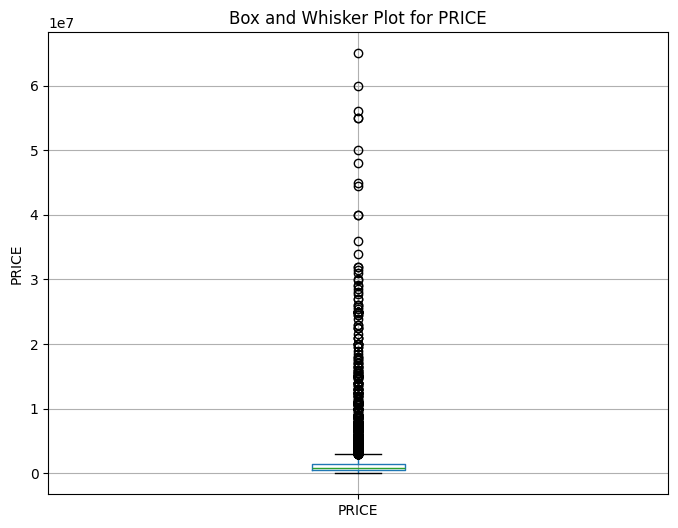

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
plt.figure(figsize=(8, 6))
df.boxplot(column=['PRICE'])
plt.title('Box and Whisker Plot for PRICE')
plt.ylabel('PRICE')
plt.show()

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
df['PRICE'].describe()

count       4798
mean     1870026
std      4066037
min         2494
25%       499000
50%       825000
75%      1495000
max     65000000
Name: PRICE, dtype: float64

In [ ]:
manhattan = df[df['LOCALITY'].isin(['New York', 'New York County'])]
bronx = df[df['LOCALITY'].isin(['The Bronx', 'Bronx County'])]
brooklyn = df[df['LOCALITY'].isin(['Brooklyn', 'Kings County', 'Flatbush'])]
staten_island = df[df['LOCALITY'] == 'Richmond County']
queens = df[df['LOCALITY'].isin(['Queens', 'Queens County'])]


In [ ]:
df['TYPE'].unique()

array(['Condo for sale', 'House for sale', 'Townhouse for sale',
       'Co-op for sale', 'Multi-family home for sale', 'For sale',
       'Contingent', 'Land for sale', 'Foreclosure', 'Pending',
       'Coming Soon', 'Mobile house for sale', 'Condop for sale'],
      dtype=object)

## Manhattan

In [ ]:
manhattan_condo = manhattan[manhattan['TYPE'] == 'Condo for sale']
manhattan_house = manhattan[manhattan['TYPE'] == 'House for sale']
manhattan_townhouse = manhattan[manhattan['TYPE'] == 'Townhouse for sale']
manhattan_coop = manhattan[manhattan['TYPE'] == 'Co-op for sale']

#### Condo

C:\Users\mjelr\AppData\Local\Temp\ipykernel_18904\1189196343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_new_york_condo.fillna(x_new_york_condo.mean(), inplace=True)  # Handling missing values


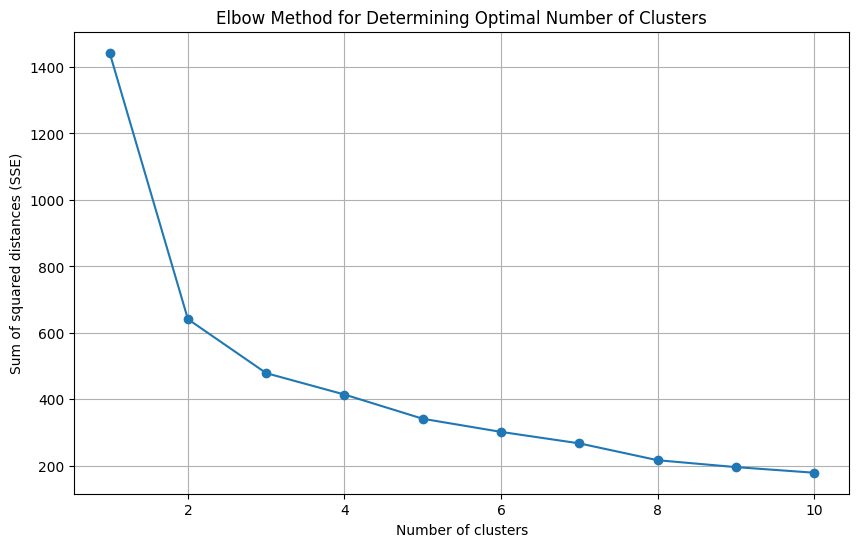

In [ ]:
# Selecting features for K-means clustering
x_new_york_condo = manhattan_condo[['BEDS', 'BATH', 'PROPERTYSQFT']]
x_new_york_condo.fillna(x_new_york_condo.mean(), inplace=True)  # Handling missing values

# Scaling the features
scaler_clustering = StandardScaler()
x_new_york_condo_clustering = scaler_clustering.fit_transform(x_new_york_condo)

# Using the Elbow Method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_new_york_condo_clustering)
    sse.append(kmeans.inertia_)

# Plotting the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances (SSE)')
plt.grid(True)
plt.show()

In [ ]:
y_new_york_condo = manhattan_condo[['PRICE']]

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(x_new_york_condo_clustering)
kmeans_features_train = kmeans.transform(x_new_york_condo_clustering)

In [ ]:
X_train_combined = np.hstack((x_new_york_condo_clustering, kmeans_features_train))
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(kmeans_features_train, y_new_york_condo)

c:\Users\mjelr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [ ]:
silhouette_avg_train = silhouette_score(x_new_york_condo_clustering, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg_train}")

Silhouette Score: 0.5668938303325292


#### House

C:\Users\mjelr\AppData\Local\Temp\ipykernel_18904\81891720.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_new_york_house.fillna(x_new_york_house.mean(), inplace=True)  # Handling missing values


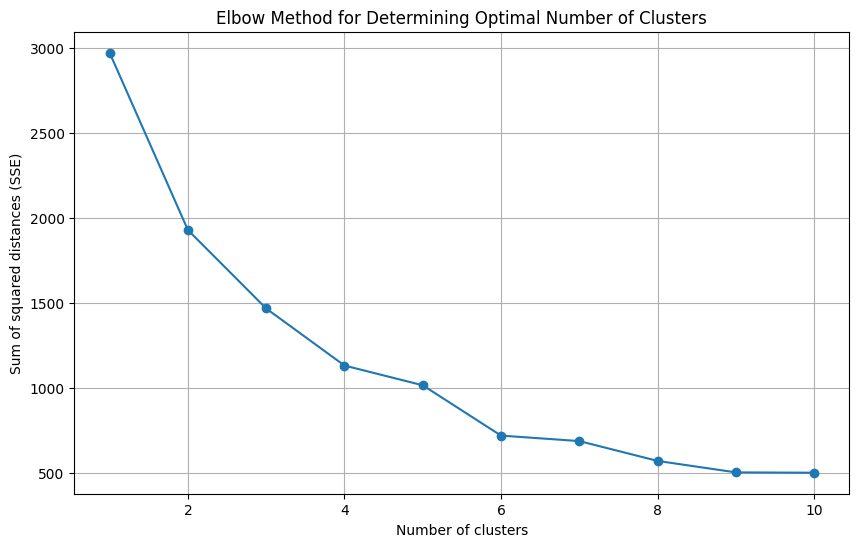

In [ ]:
# Selecting features for K-means clustering
x_new_york_house = manhattan_house[['BEDS', 'BATH', 'PROPERTYSQFT']]
x_new_york_house.fillna(x_new_york_house.mean(), inplace=True)  # Handling missing values

# Scaling the features
scaler_clustering = StandardScaler()
x_new_york_house_clustering = scaler_clustering.fit_transform(x_new_york_house)

# Using the Elbow Method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_new_york_house_clustering)
    sse.append(kmeans.inertia_)

# Plotting the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances (SSE)')
plt.grid(True)
plt.show()

In [ ]:
y_new_york_house = manhattan_house[['PRICE']]

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(x_new_york_house_clustering)
kmeans_features_train = kmeans.transform(x_new_york_house_clustering)

In [ ]:
X_train_combined = np.hstack((x_new_york_house_clustering, kmeans_features_train))
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(kmeans_features_train, y_new_york_house)

c:\Users\mjelr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [ ]:
silhouette_avg_train = silhouette_score(x_new_york_house_clustering, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg_train}")

Silhouette Score: 0.5008218729805403


#### Townhouse

C:\Users\mjelr\AppData\Local\Temp\ipykernel_18904\1944756619.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_new_york_townhouse.fillna(x_new_york_townhouse.mean(), inplace=True)  # Handling missing values


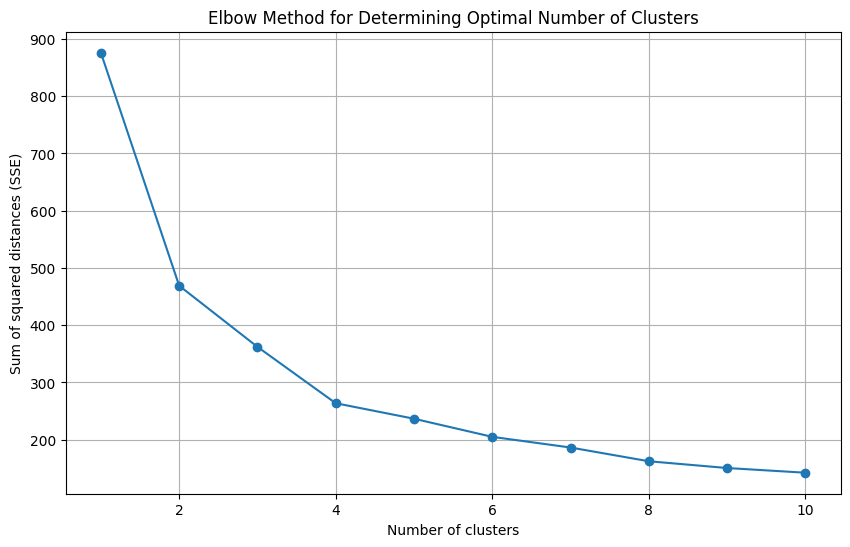

In [ ]:
# Selecting features for K-means clustering
x_new_york_townhouse = manhattan_townhouse[['BEDS', 'BATH', 'PROPERTYSQFT']]
x_new_york_townhouse.fillna(x_new_york_townhouse.mean(), inplace=True)  # Handling missing values


# Scaling the features
scaler_clustering = StandardScaler()
x_new_york_townhouse_clustering = scaler_clustering.fit_transform(x_new_york_townhouse)


# Using the Elbow Method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_new_york_townhouse_clustering)
    sse.append(kmeans.inertia_)


# Plotting the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances (SSE)')
plt.grid(True)
plt.show()

In [ ]:
y_new_york_townhouse = manhattan_townhouse[['PRICE']]

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(x_new_york_townhouse_clustering)
kmeans_features_train = kmeans.transform(x_new_york_townhouse_clustering)

X_train_combined = np.hstack((x_new_york_townhouse_clustering, kmeans_features_train))
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(kmeans_features_train, y_new_york_townhouse)

c:\Users\mjelr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [ ]:
silhouette_avg_train = silhouette_score(x_new_york_townhouse_clustering, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg_train}")

Silhouette Score: 0.38784513346405436


#### Co-op

C:\Users\mjelr\AppData\Local\Temp\ipykernel_18904\4165704680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_new_york_coop.fillna(x_new_york_coop.mean(), inplace=True)  # Handling missing values


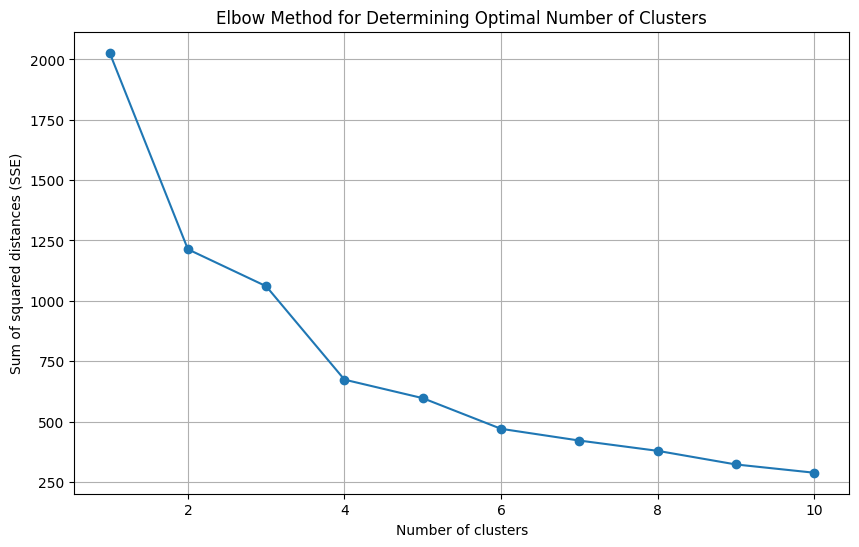

In [ ]:
# Selecting features for K-means clustering
x_new_york_coop = manhattan_coop[['BEDS', 'BATH', 'PROPERTYSQFT']]
x_new_york_coop.fillna(x_new_york_coop.mean(), inplace=True)  # Handling missing values


# Scaling the features
scaler_clustering = StandardScaler()
x_new_york_coop_clustering = scaler_clustering.fit_transform(x_new_york_coop)


# Using the Elbow Method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_new_york_coop_clustering)
    sse.append(kmeans.inertia_)


# Plotting the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances (SSE)')
plt.grid(True)
plt.show()

In [ ]:
y_new_york_coop = manhattan_coop[['PRICE']]

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(x_new_york_coop_clustering)
kmeans_features_train = kmeans.transform(x_new_york_coop_clustering)

X_train_combined = np.hstack((x_new_york_coop_clustering, kmeans_features_train))
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(kmeans_features_train, y_new_york_coop)

c:\Users\mjelr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [ ]:
silhouette_avg_train = silhouette_score(x_new_york_coop_clustering, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg_train}")

Silhouette Score: 0.4506679018252158


## The Bronx

In [ ]:
bronx_condo = bronx[bronx['TYPE'] == 'Condo for sale']
bronx_house = bronx[bronx['TYPE'] == 'House for sale']
bronx_town = bronx[bronx['TYPE'] == 'Townhouse for sale']
bronx_coop = bronx[bronx['TYPE'] == 'Co-op for sale']

#### Condo

C:\Users\mjelr\AppData\Local\Temp\ipykernel_18904\3935931076.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_bronx_condo.fillna(x_bronx_condo.mean(), inplace=True)  # Handling missing values


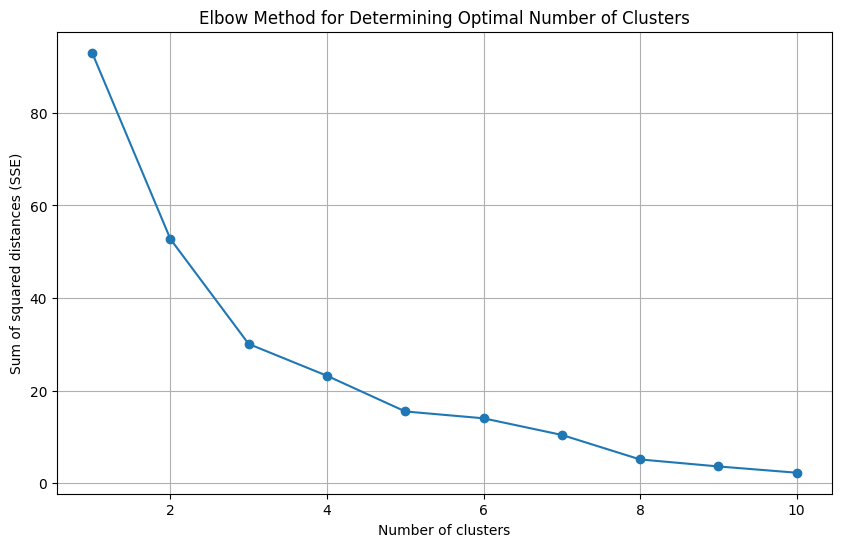

In [ ]:
# Selecting features for K-means clustering
x_bronx_condo = bronx_condo[['BEDS', 'BATH', 'PROPERTYSQFT']]
x_bronx_condo.fillna(x_bronx_condo.mean(), inplace=True)  # Handling missing values


# Scaling the features
scaler_clustering = StandardScaler()
x_bronx_condo_clustering = scaler_clustering.fit_transform(x_bronx_condo)


# Using the Elbow Method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_bronx_condo_clustering)
    sse.append(kmeans.inertia_)


# Plotting the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances (SSE)')
plt.grid(True)
plt.show()

In [ ]:
y_bronx_condo = bronx_condo[['PRICE']]

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(x_bronx_condo_clustering)
kmeans_features_train = kmeans.transform(x_bronx_condo_clustering)

X_train_combined = np.hstack((x_bronx_condo_clustering, kmeans_features_train))
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(kmeans_features_train, y_bronx_condo)

c:\Users\mjelr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [ ]:
silhouette_avg_train = silhouette_score(x_bronx_condo_clustering, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg_train}")

Silhouette Score: 0.5153409479175741


#### House

In [ ]:
bronx_house.nunique()

BROKERTITLE                    2
TYPE                           1
PRICE                          2
BEDS                           2
BATH                           2
PROPERTYSQFT                   2
ADDRESS                        2
STATE                          2
MAIN_ADDRESS                   2
ADMINISTRATIVE_AREA_LEVEL_2    1
LOCALITY                       1
SUBLOCALITY                    1
STREET_NAME                    2
LONG_NAME                      2
FORMATTED_ADDRESS              2
LATITUDE                       2
LONGITUDE                      2
dtype: int64

#### Townhouse

In [ ]:
bronx_town.nunique()

BROKERTITLE                    1
TYPE                           1
PRICE                          1
BEDS                           1
BATH                           1
PROPERTYSQFT                   1
ADDRESS                        1
STATE                          1
MAIN_ADDRESS                   1
ADMINISTRATIVE_AREA_LEVEL_2    1
LOCALITY                       1
SUBLOCALITY                    1
STREET_NAME                    1
LONG_NAME                      1
FORMATTED_ADDRESS              1
LATITUDE                       1
LONGITUDE                      1
dtype: int64

#### Co-op

C:\Users\mjelr\AppData\Local\Temp\ipykernel_18904\781024097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_bronx_coop.fillna(x_bronx_coop.mean(), inplace=True)  # Handling missing values


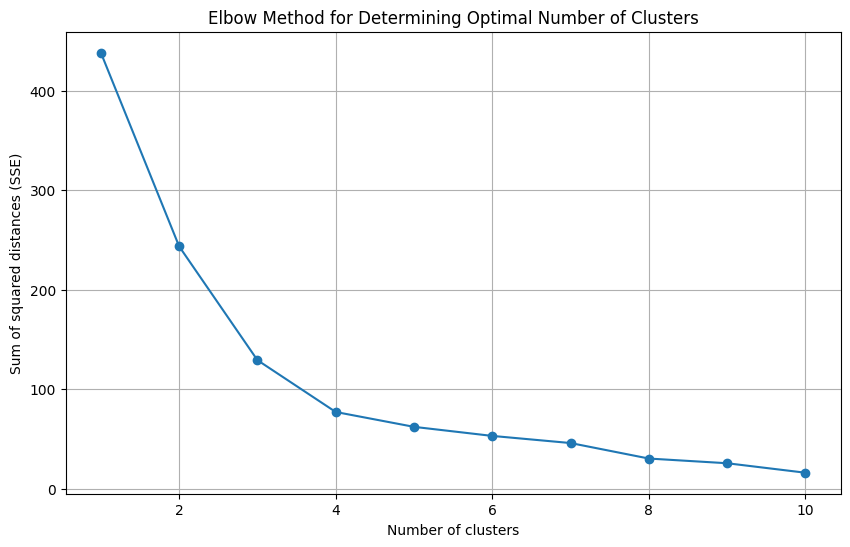

In [ ]:
# Selecting features for K-means clustering
x_bronx_coop = bronx_coop[['BEDS', 'BATH', 'PROPERTYSQFT']]
x_bronx_coop.fillna(x_bronx_coop.mean(), inplace=True)  # Handling missing values

# Scaling the features
scaler_clustering = StandardScaler()
x_bronx_coop_clustering = scaler_clustering.fit_transform(x_bronx_coop)

# Using the Elbow Method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_bronx_coop_clustering)
    sse.append(kmeans.inertia_)

# Plotting the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances (SSE)')
plt.grid(True)
plt.show()

In [ ]:
y_bronx_coop = bronx_coop[['PRICE']]

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(x_bronx_coop_clustering)
kmeans_features_train = kmeans.transform(x_bronx_coop_clustering)

X_train_combined = np.hstack((x_bronx_coop_clustering, kmeans_features_train))
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(kmeans_features_train, y_bronx_coop)

c:\Users\mjelr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [ ]:
silhouette_avg_train = silhouette_score(x_bronx_coop_clustering, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg_train}")

Silhouette Score: 0.6871753466721338


## Brooklyn

In [ ]:
kings_county_condo = brooklyn[brooklyn['TYPE'] == 'Condo for sale']
kings_county_house = brooklyn[brooklyn['TYPE'] == 'House for sale']
kings_county_town = brooklyn[brooklyn['TYPE'] == 'Townhouse for sale']
kings_county_coop = brooklyn[brooklyn['TYPE'] == 'Co-op for sale']

#### Condo

C:\Users\mjelr\AppData\Local\Temp\ipykernel_18904\1581900207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_kings_county_condo.fillna(x_kings_county_condo.mean(), inplace=True)  # Handling missing values


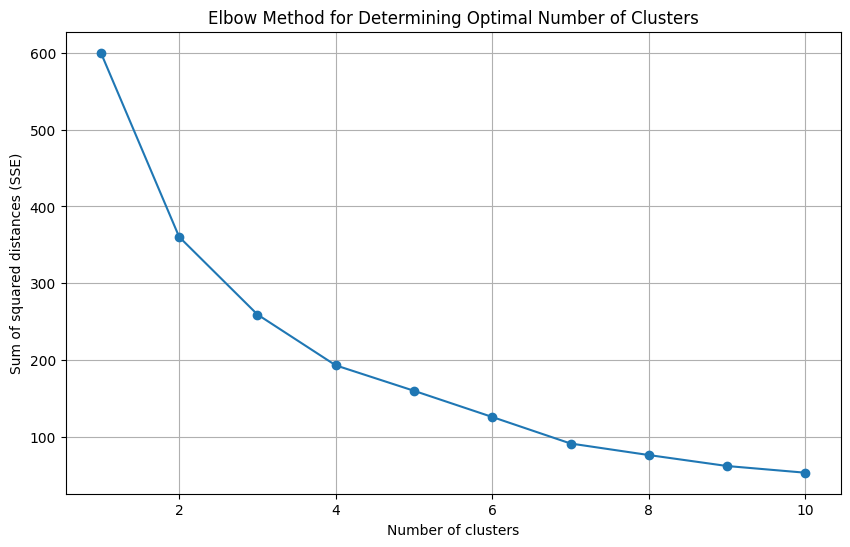

In [ ]:
# Selecting features for K-means clustering
x_kings_county_condo = kings_county_condo[['BEDS', 'BATH', 'PROPERTYSQFT']]
x_kings_county_condo.fillna(x_kings_county_condo.mean(), inplace=True)  # Handling missing values

# Scaling the features
scaler_clustering = StandardScaler()
x_kings_county_condo_clustering = scaler_clustering.fit_transform(x_kings_county_condo)

# Using the Elbow Method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_kings_county_condo_clustering)
    sse.append(kmeans.inertia_)

# Plotting the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances (SSE)')
plt.grid(True)
plt.show()

In [ ]:
y_kings_county_condo = kings_county_condo[['PRICE']]


kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(x_kings_county_condo_clustering)
kmeans_features_train = kmeans.transform(x_kings_county_condo_clustering)


X_train_combined = np.hstack((x_kings_county_condo_clustering, kmeans_features_train))
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(kmeans_features_train, y_kings_county_condo)

c:\Users\mjelr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [ ]:
silhouette_avg_train = silhouette_score(x_kings_county_condo_clustering, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg_train}")

Silhouette Score: 0.44516626145284477


#### House

In [ ]:
kings_county_house.nunique()

BROKERTITLE                    4
TYPE                           1
PRICE                          4
BEDS                           3
BATH                           3
PROPERTYSQFT                   3
ADDRESS                        4
STATE                          4
MAIN_ADDRESS                   4
ADMINISTRATIVE_AREA_LEVEL_2    1
LOCALITY                       1
SUBLOCALITY                    1
STREET_NAME                    4
LONG_NAME                      4
FORMATTED_ADDRESS              4
LATITUDE                       4
LONGITUDE                      4
dtype: int64

#### Townhouse

In [ ]:
kings_county_town.nunique()

BROKERTITLE                    2
TYPE                           1
PRICE                          4
BEDS                           3
BATH                           3
PROPERTYSQFT                   4
ADDRESS                        4
STATE                          4
MAIN_ADDRESS                   4
ADMINISTRATIVE_AREA_LEVEL_2    1
LOCALITY                       1
SUBLOCALITY                    1
STREET_NAME                    4
LONG_NAME                      4
FORMATTED_ADDRESS              4
LATITUDE                       4
LONGITUDE                      4
dtype: int64

#### Co-op

C:\Users\mjelr\AppData\Local\Temp\ipykernel_18904\3376288568.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_kings_county_coop.fillna(x_kings_county_coop.mean(), inplace=True)  # Handling missing values


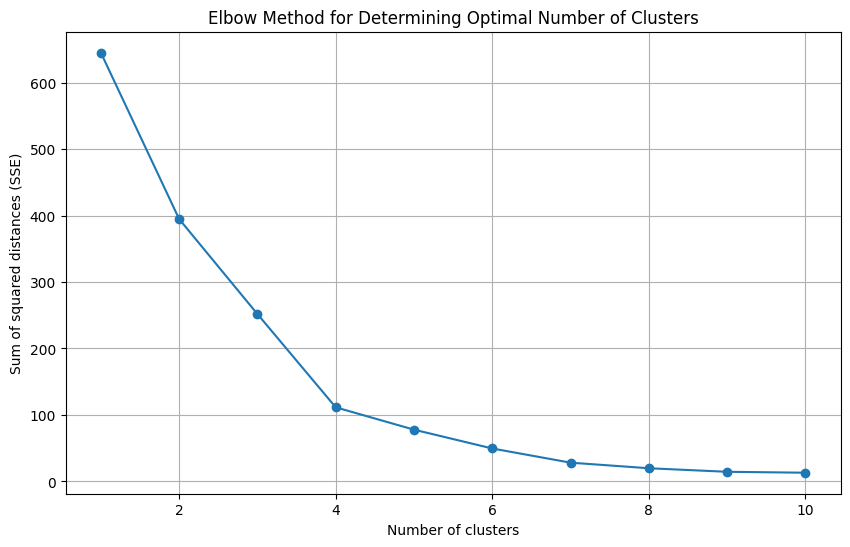

In [ ]:
# Selecting features for K-means clustering
x_kings_county_coop = kings_county_coop[['BEDS', 'BATH', 'PROPERTYSQFT']]
x_kings_county_coop.fillna(x_kings_county_coop.mean(), inplace=True)  # Handling missing values

# Scaling the features
scaler_clustering = StandardScaler()
x_kings_county_coop_clustering = scaler_clustering.fit_transform(x_kings_county_coop)

# Using the Elbow Method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_kings_county_coop_clustering)
    sse.append(kmeans.inertia_)

# Plotting the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances (SSE)')
plt.grid(True)
plt.show()

In [ ]:
y_kings_county_coop = kings_county_coop[['PRICE']]

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(x_kings_county_coop_clustering)
kmeans_features_train = kmeans.transform(x_kings_county_coop_clustering)

X_train_combined = np.hstack((x_kings_county_coop_clustering, kmeans_features_train))
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(kmeans_features_train, y_kings_county_coop)

c:\Users\mjelr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [ ]:
silhouette_avg_train = silhouette_score(x_kings_county_coop_clustering, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg_train}")

Silhouette Score: 0.6829039769216767


## Staten Island

In [ ]:
richmond_condo = staten_island[staten_island['TYPE'] == 'Condo for sale']
richmond_house = staten_island[staten_island['TYPE'] == 'House for sale']
richmond_town = staten_island[staten_island['TYPE'] == 'Townhouse for sale']
richmond_coop = staten_island[staten_island['TYPE'] == 'Co-op for sale']

#### Condo

C:\Users\mjelr\AppData\Local\Temp\ipykernel_18904\421885104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_richmond_condo.fillna(x_richmond_condo.mean(), inplace=True)  # Handling missing values


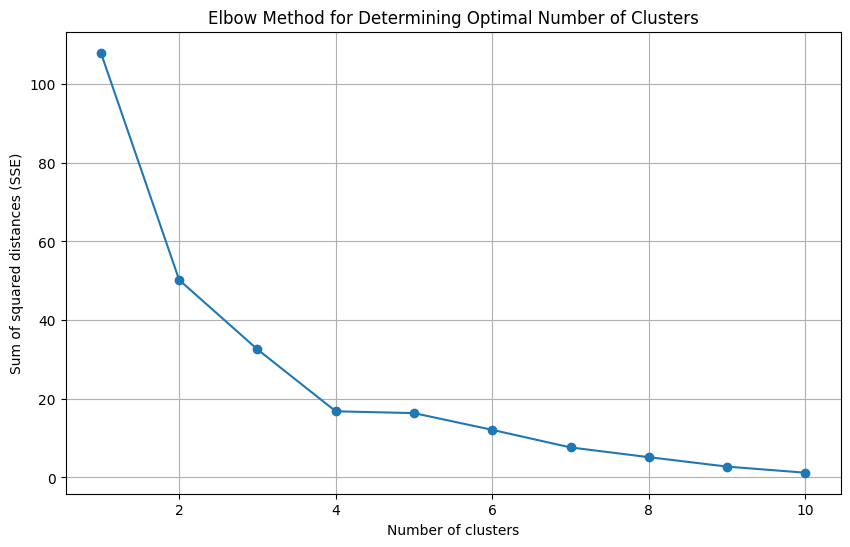

In [ ]:
# Selecting features for K-means clustering
x_richmond_condo = richmond_condo[['BEDS', 'BATH', 'PROPERTYSQFT']]
x_richmond_condo.fillna(x_richmond_condo.mean(), inplace=True)  # Handling missing values

# Scaling the features
scaler_clustering = StandardScaler()
x_richmond_condo_clustering = scaler_clustering.fit_transform(x_richmond_condo)

# Using the Elbow Method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_richmond_condo_clustering)
    sse.append(kmeans.inertia_)

# Plotting the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances (SSE)')
plt.grid(True)
plt.show()

In [ ]:
y_richmond_condo = richmond_condo[['PRICE']]

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(x_richmond_condo_clustering)
kmeans_features_train = kmeans.transform(x_richmond_condo_clustering)

X_train_combined = np.hstack((x_richmond_condo_clustering, kmeans_features_train))
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(kmeans_features_train, y_richmond_condo)

c:\Users\mjelr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [ ]:
silhouette_avg_train = silhouette_score(x_richmond_condo_clustering, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg_train}")

Silhouette Score: 0.6638239180014132


#### House

In [ ]:
richmond_house.nunique()

BROKERTITLE                    0
TYPE                           0
PRICE                          0
BEDS                           0
BATH                           0
PROPERTYSQFT                   0
ADDRESS                        0
STATE                          0
MAIN_ADDRESS                   0
ADMINISTRATIVE_AREA_LEVEL_2    0
LOCALITY                       0
SUBLOCALITY                    0
STREET_NAME                    0
LONG_NAME                      0
FORMATTED_ADDRESS              0
LATITUDE                       0
LONGITUDE                      0
dtype: int64

#### Townhouse

In [ ]:
richmond_town.nunique()

BROKERTITLE                    1
TYPE                           1
PRICE                          1
BEDS                           1
BATH                           1
PROPERTYSQFT                   1
ADDRESS                        1
STATE                          1
MAIN_ADDRESS                   1
ADMINISTRATIVE_AREA_LEVEL_2    1
LOCALITY                       1
SUBLOCALITY                    1
STREET_NAME                    1
LONG_NAME                      1
FORMATTED_ADDRESS              1
LATITUDE                       1
LONGITUDE                      1
dtype: int64

#### Co-op

In [ ]:
richmond_coop.nunique()

BROKERTITLE                    5
TYPE                           1
PRICE                          5
BEDS                           2
BATH                           1
PROPERTYSQFT                   4
ADDRESS                        5
STATE                          2
MAIN_ADDRESS                   5
ADMINISTRATIVE_AREA_LEVEL_2    1
LOCALITY                       1
SUBLOCALITY                    1
STREET_NAME                    2
LONG_NAME                      3
FORMATTED_ADDRESS              5
LATITUDE                       4
LONGITUDE                      4
dtype: int64

In [ ]:
brooklyn.nunique()

BROKERTITLE                    5
TYPE                           2
PRICE                          6
BEDS                           2
BATH                           3
PROPERTYSQFT                   6
ADDRESS                        6
STATE                          3
MAIN_ADDRESS                   6
ADMINISTRATIVE_AREA_LEVEL_2    1
LOCALITY                       1
SUBLOCALITY                    4
STREET_NAME                    4
LONG_NAME                      4
FORMATTED_ADDRESS              6
LATITUDE                       4
LONGITUDE                      4
dtype: int64

## Queens

In [ ]:
queens_condo = queens[queens['TYPE'] == 'Condo for sale']
queens_house = queens[queens['TYPE'] == 'House for sale']
queens_town = queens[queens['TYPE'] == 'Townhouse for sale']
queens_coop = queens[queens['TYPE'] == 'Co-op for sale']

#### Condo

In [ ]:
queens_condo.nunique()

BROKERTITLE                     74
TYPE                             1
PRICE                          101
BEDS                             4
BATH                             3
PROPERTYSQFT                    79
ADDRESS                        133
STATE                           48
MAIN_ADDRESS                   133
ADMINISTRATIVE_AREA_LEVEL_2      2
LOCALITY                         2
SUBLOCALITY                      2
STREET_NAME                     25
LONG_NAME                      121
FORMATTED_ADDRESS              133
LATITUDE                       122
LONGITUDE                      122
dtype: int64

C:\Users\mjelr\AppData\Local\Temp\ipykernel_18904\3737601531.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_queens_condo.fillna(x_queens_condo.mean(), inplace=True)  # Handling missing values


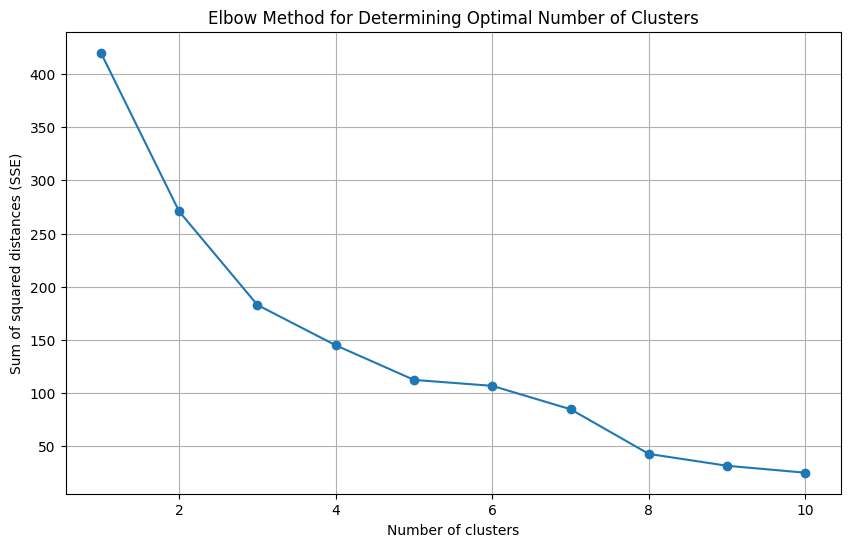

In [ ]:
# Selecting features for K-means clustering
x_queens_condo = queens_condo[['BEDS', 'BATH', 'PROPERTYSQFT']]
x_queens_condo.fillna(x_queens_condo.mean(), inplace=True)  # Handling missing values


# Scaling the features
scaler_clustering = StandardScaler()
x_queens_condo_clustering = scaler_clustering.fit_transform(x_queens_condo)


# Using the Elbow Method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_queens_condo_clustering)
    sse.append(kmeans.inertia_)


# Plotting the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances (SSE)')
plt.grid(True)
plt.show()

In [ ]:
y_queens_condo = queens_condo[['PRICE']]


kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(x_queens_condo_clustering)
kmeans_features_train = kmeans.transform(x_queens_condo_clustering)


X_train_combined = np.hstack((x_queens_condo_clustering, kmeans_features_train))
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(kmeans_features_train, y_queens_condo)


c:\Users\mjelr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [ ]:
silhouette_avg_train = silhouette_score(x_queens_condo_clustering, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg_train}")

Silhouette Score: 0.5104966538956638


#### House

In [ ]:
queens_house.nunique()

BROKERTITLE                    1
TYPE                           1
PRICE                          1
BEDS                           1
BATH                           1
PROPERTYSQFT                   1
ADDRESS                        1
STATE                          1
MAIN_ADDRESS                   1
ADMINISTRATIVE_AREA_LEVEL_2    1
LOCALITY                       1
SUBLOCALITY                    1
STREET_NAME                    1
LONG_NAME                      1
FORMATTED_ADDRESS              1
LATITUDE                       1
LONGITUDE                      1
dtype: int64

#### Townhouse

In [ ]:
queens_town.nunique()

BROKERTITLE                    0
TYPE                           0
PRICE                          0
BEDS                           0
BATH                           0
PROPERTYSQFT                   0
ADDRESS                        0
STATE                          0
MAIN_ADDRESS                   0
ADMINISTRATIVE_AREA_LEVEL_2    0
LOCALITY                       0
SUBLOCALITY                    0
STREET_NAME                    0
LONG_NAME                      0
FORMATTED_ADDRESS              0
LATITUDE                       0
LONGITUDE                      0
dtype: int64

#### Co-op

C:\Users\mjelr\AppData\Local\Temp\ipykernel_18904\2205522797.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_queens_coop.fillna(x_queens_coop.mean(), inplace=True)  # Handling missing values


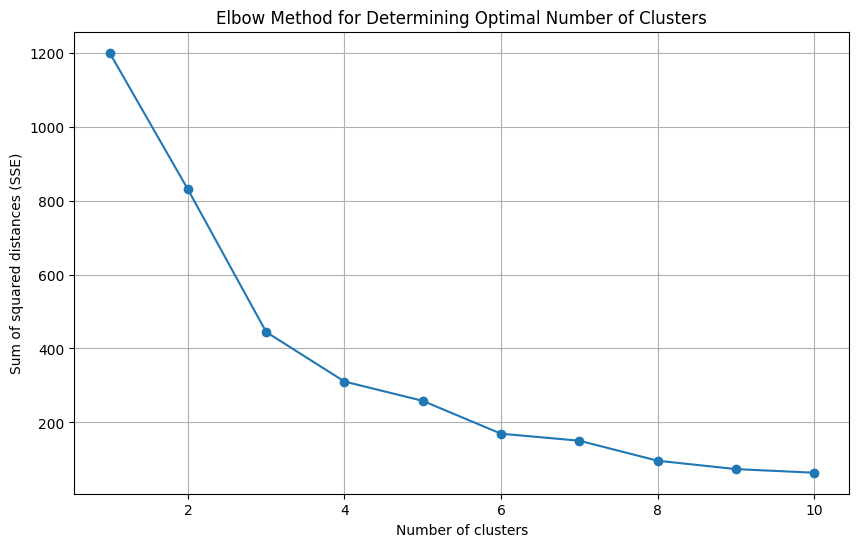

In [ ]:
# Selecting features for K-means clustering
x_queens_coop = queens_coop[['BEDS', 'BATH', 'PROPERTYSQFT']]
x_queens_coop.fillna(x_queens_coop.mean(), inplace=True)  # Handling missing values

# Scaling the features
scaler_clustering = StandardScaler()
x_queens_coop_clustering = scaler_clustering.fit_transform(x_queens_coop)

# Using the Elbow Method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_queens_coop_clustering)
    sse.append(kmeans.inertia_)

# Plotting the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances (SSE)')
plt.grid(True)
plt.show()

In [ ]:
y_queens_coop = queens_coop[['PRICE']]

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(x_queens_coop_clustering)
kmeans_features_train = kmeans.transform(x_queens_coop_clustering)

X_train_combined = np.hstack((x_queens_coop_clustering, kmeans_features_train))
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(kmeans_features_train, y_queens_coop)

c:\Users\mjelr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [ ]:
silhouette_avg_train = silhouette_score(x_queens_coop_clustering, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg_train}")

Silhouette Score: 0.5643345035364148


# **Linear Regression**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import statsmodels.api as sm

# Load and prepare data
data = pd.read_csv('NY-House-Dataset.csv')

translations = {
    "New York": "New York County",  # Generally refers to Manhattan
    "Kings County": "Kings County",  # Brooklyn
    "Queens County": "Queens County",
    "Queens": "Queens County",
    "Richmond County": "Richmond County",  # Staten Island
    "Brooklyn": "Kings County",
    "Bronx County": "Bronx County",
    "New York County": "New York County",  # Manhattan
    "The Bronx": "Bronx County",
    "Staten Island": "Richmond County",
    "Manhattan": "New York County",
    "Riverdale": "Bronx County",  # Neighborhood in The Bronx
    "Flushing": "Queens County", # Neighborhood in Queens
    "Coney Island": "Kings County",  # Neighborhood in Brooklyn
    "East Bronx": "Bronx County",  # Part of The Bronx
    "Brooklyn Heights": "Kings County",  # Neighborhood in Brooklyn
    "Jackson Heights": "Queens County",  # Neighborhood in Queens
    "Rego Park": "Queens County",  # Neighborhood in Queens
    "Fort Hamilton": "Kings County",  # Neighborhood in Brooklyn
    "Dumbo": "Kings County",  # Neighborhood in Brooklyn
    "Snyder Avenue": "Kings County"  # Assuming this is in Brooklyn; otherwise, needs correction
}

data["SUBLOCALITY"] = data["SUBLOCALITY"].apply(lambda row: translations[row])

data["SUBLOCALITY"].nunique()

# Select variables
selected_columns = ['TYPE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'PRICE', 'SUBLOCALITY']
selected_data = data[selected_columns]

# Remove outliers for PRICE first
Q1_price = selected_data['PRICE'].quantile(0.25)
Q3_price = selected_data['PRICE'].quantile(0.75)
IQR_price = Q3_price - Q1_price
price_filter = (selected_data['PRICE'] >= Q1_price - 1.5 * IQR_price) & (selected_data['PRICE'] <= Q3_price + 1.5 * IQR_price)
selected_data = selected_data[price_filter]

# Log transform of PRICE after removing outliers
selected_data['LOG_PRICE'] = np.log(selected_data['PRICE'] + 1)

# Create interaction terms
selected_data['BEDSxBATH'] = selected_data['BEDS'] * selected_data['BATH']

# Further remove outliers based on other features
features_to_check = ['BEDS', 'BATH', 'PROPERTYSQFT', 'BEDSxBATH']
for feature in features_to_check:
    Q1 = selected_data[feature].quantile(0.25)
    Q3 = selected_data[feature].quantile(0.75)
    IQR = Q3 - Q1
    selected_data = selected_data[(selected_data[feature] >= Q1 - 1.5 * IQR) & (selected_data[feature] <= Q3 + 1.5 * IQR)]

# Reset indices after filtering
selected_data.reset_index(drop=True, inplace=True)

# Encode categorical variables
encoder = OneHotEncoder(drop='first')
encoded_categorical = encoder.fit_transform(selected_data[['TYPE', 'SUBLOCALITY']]).toarray()
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(['TYPE', 'SUBLOCALITY']))

# Standardize numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(selected_data[['BEDS', 'BATH', 'PROPERTYSQFT', 'BEDSxBATH']])
numerical_df = pd.DataFrame(scaled_numerical, columns=['BEDS', 'BATH', 'PROPERTYSQFT', 'BEDSxBATH'])

# Combine features
features = pd.concat([numerical_df, encoded_df], axis=1)  # Indices should align as both are reset or aligned after filtering
target = selected_data['LOG_PRICE']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Fit model
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_sm)
result = model.fit()

print(result.summary())



In [ ]:
# List of statistically significant predictors (including the baseline 'const')
significant_predictors = [
    'const','BEDS', 'BATH', 'PROPERTYSQFT', 'TYPE_Condo for sale', 'TYPE_Contingent',
    'TYPE_For sale', 'TYPE_House for sale', 'TYPE_Land for sale',
    'TYPE_Multi-family home for sale', 'TYPE_Pending', 'TYPE_Townhouse for sale',
    'SUBLOCALITY_Kings County', 'SUBLOCALITY_New York County',
    'SUBLOCALITY_Queens County', 'SUBLOCALITY_Richmond County'
]

# Subset the training data to include only significant predictors
X_train_significant = X_train_sm[significant_predictors]

# Refit model with significant predictors only
model_significant = sm.OLS(y_train, X_train_significant)
result_significant = model_significant.fit()

# Print the summary of the new model
print(result_significant.summary())


In [ ]:
# Assuming 'result' is the fit result from your statsmodels OLS regression
p_values = result.pvalues  # Extracting p-values from the model result

# Filtering predictors with p-values less than or equal to 0.05
significant_predictors = p_values[p_values <= 0.05].index.tolist()

# Creating a DataFrame with significant predictors
# Note: You can also include their coefficients if needed
coefficients = result.params[significant_predictors]
std_errors = result.bse[significant_predictors]

# Creating DataFrame
significant_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Standard Error': std_errors,
    'P-Value': p_values[significant_predictors]
})

print(significant_df)

In [ ]:
from sklearn.metrics import mean_squared_error

# Add constant to test features
X_test_sm = sm.add_constant(X_test)

# Predict using the fitted model
y_pred = result.predict(X_test_sm)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
